In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import matplotlib.pyplot as plt
from torch import nn, optim

In [4]:
ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [5]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        input = input.reshape(-1, 100).float()
        combined = torch.cat([input, hidden], dim=1)
        hidden_new = self.i2h(combined)
        output = self.i2o(combined)
        #output = self.softmax(output)
        output = output.reshape(-1, 60, 2)
        return output, hidden_new

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [46]:
def train(rnn, opt, train_dataset, train_loader, val_dataset, val_loader, criterion):
    device = torch.device('cuda:0')
    rnn = rnn.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):
        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            #print(inp.size())
            out = out.to(device)
            inp = inp.to(device)
            out = out.float()
            hidden = rnn.initHidden(batch_size)
            hidden = hidden.to(device)
            preds, hidden = rnn(inp, hidden)
            
            #loss = criterion(preds, out)
            loss = ((preds - out) ** 2).sum()
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            total_loss += loss.item()
            
        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            hidden = rnn.initHidden(batch_size)
            hidden = hidden.to(device)
            preds, hidden = rnn(inp, hidden)
            
            #loss = criterion(preds, out)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()
        
        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        #print('epoch {} train_loss: {}'.format(epoch, train_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.7044523370377 val_loss: 15.015791882441517
epoch 1 train_loss: 13.88909385145666 val_loss: 12.441054227843837
epoch 2 train_loss: 11.987934620938992 val_loss: 11.767668466847384
epoch 3 train_loss: 11.734859680081167 val_loss: 11.72828101172016
epoch 4 train_loss: 11.721987833628305 val_loss: 11.725181968569064
epoch 5 train_loss: 11.71959445977937 val_loss: 11.722770925579738
epoch 6 train_loss: 11.717126743990486 val_loss: 11.719903709109357
epoch 7 train_loss: 11.714216528278323 val_loss: 11.716788017778883
epoch 8 train_loss: 11.710854219151054 val_loss: 11.713440342795852
epoch 9 train_loss: 11.707028594272632 val_loss: 11.710379052750971
epoch 10 train_loss: 11.70272561912432 val_loss: 11.707457630064443
epoch 11 train_loss: 11.697923635571774 val_loss: 11.703626999212748
epoch 12 train_loss: 11.69256284370884 val_loss: 11.698389311047203
epoch 13 train_loss: 11.686512027429629 val_loss: 11.692243743345415
epoch 14 train_loss: 11.67963635102504

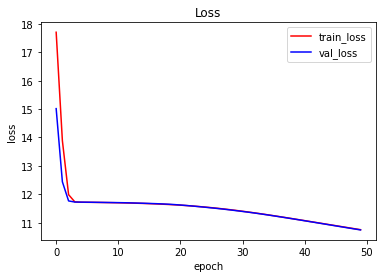

city: miami
epoch 0 train_loss: 19.088671377063324 val_loss: 14.498017345173357
epoch 1 train_loss: 12.9338961631356 val_loss: 11.447513837000589
epoch 2 train_loss: 11.427702110798867 val_loss: 11.416521375522557
epoch 3 train_loss: 11.423180032970091 val_loss: 11.42091426856601
epoch 4 train_loss: 11.422960368697321 val_loss: 11.4251866627235
epoch 5 train_loss: 11.422522933495905 val_loss: 11.426583234537729
epoch 6 train_loss: 11.421804547731256 val_loss: 11.426384467647466
epoch 7 train_loss: 11.420629979142877 val_loss: 11.428248767295122
epoch 8 train_loss: 11.419137695027736 val_loss: 11.433485485094868
epoch 9 train_loss: 11.417433322447186 val_loss: 11.437760829724427
epoch 10 train_loss: 11.41538118066296 val_loss: 11.438559334659612
epoch 11 train_loss: 11.412738365873574 val_loss: 11.437318153337625
epoch 12 train_loss: 11.409573445890164 val_loss: 11.43310325141027
epoch 13 train_loss: 11.405490180113011 val_loss: 11.427179348100411
epoch 14 train_loss: 11.40067326857343 

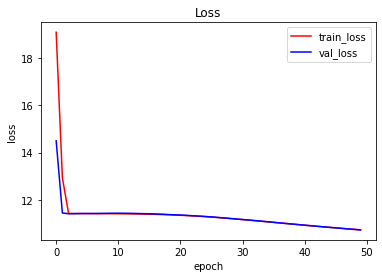

city: pittsburgh
epoch 0 train_loss: 18.87495180965133 val_loss: 16.244066505467696
epoch 1 train_loss: 15.27364215986023 val_loss: 13.86885574848194
epoch 2 train_loss: 12.926327435625565 val_loss: 11.926384215601773
epoch 3 train_loss: 11.660011442178495 val_loss: 11.527917244003232
epoch 4 train_loss: 11.531386353511976 val_loss: 11.510222631937078
epoch 5 train_loss: 11.526372245651638 val_loss: 11.508634637967408
epoch 6 train_loss: 11.52528395139086 val_loss: 11.506167298867972
epoch 7 train_loss: 11.524121462365146 val_loss: 11.504400437017349
epoch 8 train_loss: 11.522815779839627 val_loss: 11.503326976639336
epoch 9 train_loss: 11.521386783715263 val_loss: 11.502267245330117
epoch 10 train_loss: 11.519806241554914 val_loss: 11.501257261604666
epoch 11 train_loss: 11.517943362348543 val_loss: 11.49984515265844
epoch 12 train_loss: 11.515709274818105 val_loss: 11.496422035344791
epoch 13 train_loss: 11.513031630713806 val_loss: 11.493167904682695
epoch 14 train_loss: 11.50992869

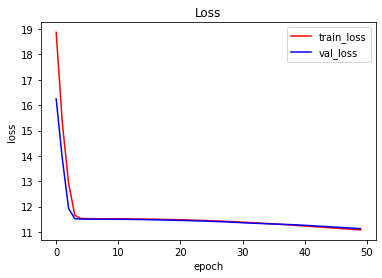

city: dearborn
epoch 0 train_loss: 20.95221020158448 val_loss: 18.402568395983852
epoch 1 train_loss: 17.979075672278917 val_loss: 17.628543077693905
epoch 2 train_loss: 17.36452707728283 val_loss: 17.05008423518079
epoch 3 train_loss: 16.776768335090328 val_loss: 16.45250175663228
epoch 4 train_loss: 16.168394743954398 val_loss: 15.833268884087735
epoch 5 train_loss: 15.537089290389725 val_loss: 15.191253421305513
epoch 6 train_loss: 14.884489680756664 val_loss: 14.533514154668852
epoch 7 train_loss: 14.223964444624713 val_loss: 13.883372039610268
epoch 8 train_loss: 13.588897553656484 val_loss: 13.286908163000593
epoch 9 train_loss: 13.035803847260295 val_loss: 12.806134058271981
epoch 10 train_loss: 12.624284032763567 val_loss: 12.48288737573699
epoch 11 train_loss: 12.372668728016224 val_loss: 12.30396317770073
epoch 12 train_loss: 12.244687624653658 val_loss: 12.219215567365794
epoch 13 train_loss: 12.18789801078963 val_loss: 12.183019990802833
epoch 14 train_loss: 12.164827166856

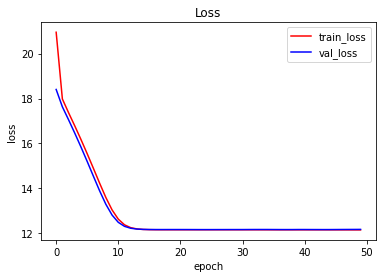

city: washington-dc
epoch 0 train_loss: 19.49477070765856 val_loss: 16.930833942765737
epoch 1 train_loss: 16.579593725092597 val_loss: 16.232292329149956
epoch 2 train_loss: 15.924514042995657 val_loss: 15.57848302381676
epoch 3 train_loss: 15.265643272729045 val_loss: 14.908641531798567
epoch 4 train_loss: 14.59035253933156 val_loss: 14.221850675945378
epoch 5 train_loss: 13.903446281394118 val_loss: 13.529835080932228
epoch 6 train_loss: 13.227233636037644 val_loss: 12.868767826934802
epoch 7 train_loss: 12.613702620405165 val_loss: 12.30741078998432
epoch 8 train_loss: 12.13794419119168 val_loss: 11.917461638397768
epoch 9 train_loss: 11.844870780276622 val_loss: 11.707547177258887
epoch 10 train_loss: 11.70400594876215 val_loss: 11.618533384454095
epoch 11 train_loss: 11.648834066876693 val_loss: 11.587092877970875
epoch 12 train_loss: 11.630158887233844 val_loss: 11.577352389550894
epoch 13 train_loss: 11.624395408921831 val_loss: 11.574461620189316
epoch 14 train_loss: 11.622621

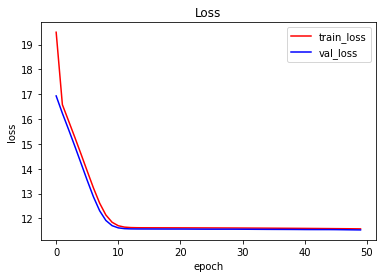

city: palo-alto
epoch 0 train_loss: 18.956768558468234 val_loss: 17.956544535092004
epoch 1 train_loss: 17.382232253530614 val_loss: 16.569052752315713
epoch 2 train_loss: 16.01936478191684 val_loss: 15.228344240509248
epoch 3 train_loss: 14.697716401265266 val_loss: 13.959026847534421
epoch 4 train_loss: 13.502084760012687 val_loss: 12.92243228856535
epoch 5 train_loss: 12.635615246001155 val_loss: 12.318863858860617
epoch 6 train_loss: 12.220255454114874 val_loss: 12.09743712712678
epoch 7 train_loss: 12.090951991294439 val_loss: 12.040283591506167
epoch 8 train_loss: 12.06001865915156 val_loss: 12.027956622171278
epoch 9 train_loss: 12.053317899591875 val_loss: 12.025275383252087
epoch 10 train_loss: 12.051592602178175 val_loss: 12.0243170102454
epoch 11 train_loss: 12.050731762173582 val_loss: 12.023565493907556
epoch 12 train_loss: 12.049977999215242 val_loss: 12.022790703951891
epoch 13 train_loss: 12.049210841523918 val_loss: 12.021982336821127
epoch 14 train_loss: 12.0484124117

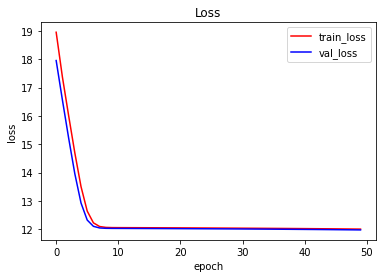

CPU times: user 2min 18s, sys: 5.62 s, total: 2min 23s
Wall time: 2min 21s


In [47]:
%%time
import pickle
batch_size = 128
#train city models
for city in cities:
    print('city: ' + city)
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_size, drop_last = True)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_size, drop_last = True)
    
    rnn = RNN(100, 64, 120)
    lr = 2e-4
    opt = optim.Adam(rnn.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train(rnn, opt, train_dataset, train_loader, val_dataset, val_loader, criterion)
    pickle.dump(rnn, open('rnn_' + city, 'wb'))

In [42]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('rnn_' + city, 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device), torch.zeros(len(test_dataset[0]), 64).to(device))
    preds_reshaped = preds[0].reshape(preds[0].size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [43]:
all_predictions

ID           v0           v1           v2           v3  \
0            0_austin    -3.156717  -566.571777    -4.140568  -569.047424   
1            1_austin  -344.540405    16.115396  -347.573822    17.989170   
2            2_austin    51.508858  -247.677063    51.458351  -247.905167   
3            3_austin  -118.548073  1797.092285  -118.022995  1799.070923   
4            4_austin  1188.828491  -638.718750  1188.784790  -635.319397   
...               ...          ...          ...          ...          ...   
29838  1681_palo-alto -1373.567383  -466.052155 -1373.874023  -458.500519   
29839  1682_palo-alto   127.215981   -38.840332   130.250839   -35.728573   
29840  1683_palo-alto -1440.360840  2163.703125 -1440.945312  2163.698975   
29841  1684_palo-alto  1055.489990  1395.217163  1055.169067  1386.855225   
29842  1685_palo-alto   -66.911652   454.514709   -74.591713   433.131470   

                v4           v5           v6           v7           v8  ...  \
0        -4.343686  -567.667236    -2.087635  -567.544739    -1.140520  ...   
1      -346.929108    15.594349  -347.326355    13.148594  -348.971649  ...   
2        51.490334  -247.827393    50.941227  -247.658447    50.707199  ...   
3      -118.118340  1798.766602  -113.959618  1797.910156  -112.814346  ...   
4      1189.643433  -636.956055  1181.602783  -637.076233  1178.593994  ...   
...            ...          ...          ...          ...          ...  ...   
29838 -1371.952881  -458.625580 -1375.321899  -454.839050 -1376.476562  ...   
29839   128.162674   -38.740795   131.637497   -42.827358   133.243607  ...   
29840 -1441.142334  2164.095703 -1437.980591  2161.894775 -1440.368652  ...   
29841  1053.560059  1387.289307  1057.838989  1385.484009  1057.332153  ...   
29842   -70.882195   440.871857   -74.526245   445.242371   -77.301010  ...   

              v110         v111         v112         v113         v114  \
0       -22.240969  -563.311157   -20.701729  -563.714172    -6.718290   
1      -344.577820     8.366800  -344.212463    10.675669  -344.957306   
2        52.108448  -248.182831    52.228977  -248.231232    52.143063   
3      -123.028870  1802.445190  -123.035896  1802.677734  -123.425522   
4      1216.844360  -646.139160  1215.135376  -646.123596  1195.515625   
...            ...          ...          ...          ...          ...   
29838 -1367.614502  -456.799927 -1370.193604  -461.587524 -1376.564087   
29839   129.053101   -38.315048   127.925346   -36.945736   133.243607   
29840 -1442.449463  2163.044434 -1442.845093  2158.727783 -1445.323120   
29841  1048.364624  1385.652344  1050.358643  1389.011353  1054.022095   
29842   -76.053986   438.340393   -69.983170   436.298126   -75.059128   

              v115         v116         v117         v118         v119  
0      -557.672974   -19.965569  -559.985779   -16.099594  -564.434937  
1         0.832046  -345.456543     5.653030  -343.722931     9.776310  
2      -247.860504    52.221905  -248.070297    52.206360  -248.346436  
3      1802.205933  -123.245361  1801.958618  -123.570000  1802.841919  
4      -651.593811  1214.141602  -649.585327  1208.864380  -645.754700  
...            ...          ...          ...          ...          ...  
29838  -455.343811 -1370.207520  -454.910950 -1376.688721  -453.021973  
29839   -40.334984   127.276115   -36.527546   132.438370   -40.071178  
29840  2157.360107 -1439.342896  2163.407959 -1443.760132  2159.448242  
29841  1382.530029  1051.838989  1383.614258  1054.406372  1381.580933  
29842   435.272064   -65.799339   431.365356   -70.584755   430.948364  

[29843 rows x 121 columns]

In [44]:
all_predictions.to_csv('temp_out.csv', index=False)

In [45]:
pd.read_csv('temp_out.csv')

ID           v0           v1           v2           v3  \
0            0_austin    -3.156717  -566.571800    -4.140568  -569.047400   
1            1_austin  -344.540400    16.115396  -347.573820    17.989170   
2            2_austin    51.508858  -247.677060    51.458350  -247.905170   
3            3_austin  -118.548070  1797.092300  -118.022995  1799.070900   
4            4_austin  1188.828500  -638.718750  1188.784800  -635.319400   
...               ...          ...          ...          ...          ...   
29838  1681_palo-alto -1373.567400  -466.052150 -1373.874000  -458.500520   
29839  1682_palo-alto   127.215980   -38.840332   130.250840   -35.728573   
29840  1683_palo-alto -1440.360800  2163.703100 -1440.945300  2163.699000   
29841  1684_palo-alto  1055.490000  1395.217200  1055.169100  1386.855200   
29842  1685_palo-alto   -66.911650   454.514700   -74.591710   433.131470   

                v4           v5           v6           v7          v8  ...  \
0        -4.343686  -567.667240    -2.087635  -567.544740    -1.14052  ...   
1      -346.929100    15.594349  -347.326350    13.148594  -348.97165  ...   
2        51.490334  -247.827400    50.941227  -247.658450    50.70720  ...   
3      -118.118340  1798.766600  -113.959620  1797.910200  -112.81435  ...   
4      1189.643400  -636.956050  1181.602800  -637.076230  1178.59400  ...   
...            ...          ...          ...          ...         ...  ...   
29838 -1371.952900  -458.625580 -1375.321900  -454.839050 -1376.47660  ...   
29839   128.162670   -38.740795   131.637500   -42.827360   133.24360  ...   
29840 -1441.142300  2164.095700 -1437.980600  2161.894800 -1440.36870  ...   
29841  1053.560000  1387.289300  1057.839000  1385.484000  1057.33220  ...   
29842   -70.882195   440.871860   -74.526245   445.242370   -77.30101  ...   

              v110        v111         v112         v113         v114  \
0       -22.240969  -563.31116   -20.701729  -563.714200    -6.718290   
1      -344.577820     8.36680  -344.212460    10.675669  -344.957300   
2        52.108448  -248.18283    52.228977  -248.231230    52.143063   
3      -123.028870  1802.44520  -123.035900  1802.677700  -123.425520   
4      1216.844400  -646.13916  1215.135400  -646.123600  1195.515600   
...            ...         ...          ...          ...          ...   
29838 -1367.614500  -456.79993 -1370.193600  -461.587520 -1376.564100   
29839   129.053100   -38.31505   127.925350   -36.945736   133.243600   
29840 -1442.449500  2163.04440 -1442.845100  2158.727800 -1445.323100   
29841  1048.364600  1385.65230  1050.358600  1389.011400  1054.022100   
29842   -76.053986   438.34040   -69.983170   436.298130   -75.059130   

              v115         v116         v117         v118        v119  
0      -557.673000   -19.965569  -559.985800   -16.099594  -564.43494  
1         0.832046  -345.456540     5.653030  -343.722930     9.77631  
2      -247.860500    52.221905  -248.070300    52.206360  -248.34644  
3      1802.205900  -123.245360  1801.958600  -123.570000  1802.84190  
4      -651.593800  1214.141600  -649.585300  1208.864400  -645.75470  
...            ...          ...          ...          ...         ...  
29838  -455.343800 -1370.207500  -454.910950 -1376.688700  -453.02197  
29839   -40.334984   127.276115   -36.527546   132.438370   -40.07118  
29840  2157.360000 -1439.342900  2163.408000 -1443.760100  2159.44820  
29841  1382.530000  1051.839000  1383.614300  1054.406400  1381.58090  
29842   435.272060   -65.799340   431.365360   -70.584755   430.94836  

[29843 rows x 121 columns]